<center>
    <h1>Deep Learning for Natural Language Processing</h1>
</center>

In this notebook we will develop a **sentiment classifier** on a given English-language **Twitter Dataset** containing some user comments. The main goal is to build a model that understands whether a specific comment has a **positive** sentiment or a **negative** sentiment.

## Loading the Datasets 📥🗂️

We will  begin by importing the **dataset** we are going to work with. The provided dataset consists of **3 CSV files** each one having its significant role in the process. We have the **training**, **validating** and **testing** files.
1. The training file is going to be used to train our model.
2. The validating file will tell us how good our model is by computing its accuracy.
3. The testing file is going to be used to test our model and extract some results and statistics.

Let's load our dataset files that are located in the `/Data/` directory.

In [1129]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

dataset_base_filepath = '../Data/Raw' # "/kaggle/input/ai-2-deep-learning-for-nlp-homework-1"
images_base_filepath = '../imgs' # "/kaggle/input/images"

# Load all the dataset files using pandas and store inside some dataframe variables
train_df = pd.read_csv(f'{dataset_base_filepath}/train_dataset.csv')
val_df = pd.read_csv(f'{dataset_base_filepath}/val_dataset.csv')
test_df = pd.read_csv(f'{dataset_base_filepath}/test_dataset.csv')

# Reduce the data sizes
size=1
train_df = train_df.sample(frac=size)
val_df = val_df.sample(frac=size)
# test_df = test_df.sample(frac=size)

print(train_df.shape, val_df.shape, test_df.shape)

(148388, 3) (42396, 3) (21199, 2)


Let's take a look at some of the records of the training dataset.

In [1130]:
train_df.head()

,ID,Text,Label
53149,11245,tomorrow fb is leaving,0
119783,70451,@kyletamo My copy finally arrived. Sounds awe...,1
60918,170595,10% battery remaining on iTouch.. No music... ...,0
70124,71169,@dddani_ I haven't watched Taken yet. Heard i...,1
86977,49305,Just finished taking world geograhy final!!! I...,0


### Data sizes 📏📐

Let's have a look at the **sizes** of these datasets. In machine learning a **suitable size** of training, validating and testing data is around 70%, 20% and 10% respectively. 

Training Dataset size: 445164
Validating Dataset size: 127188
Testing Dataset size: 42398


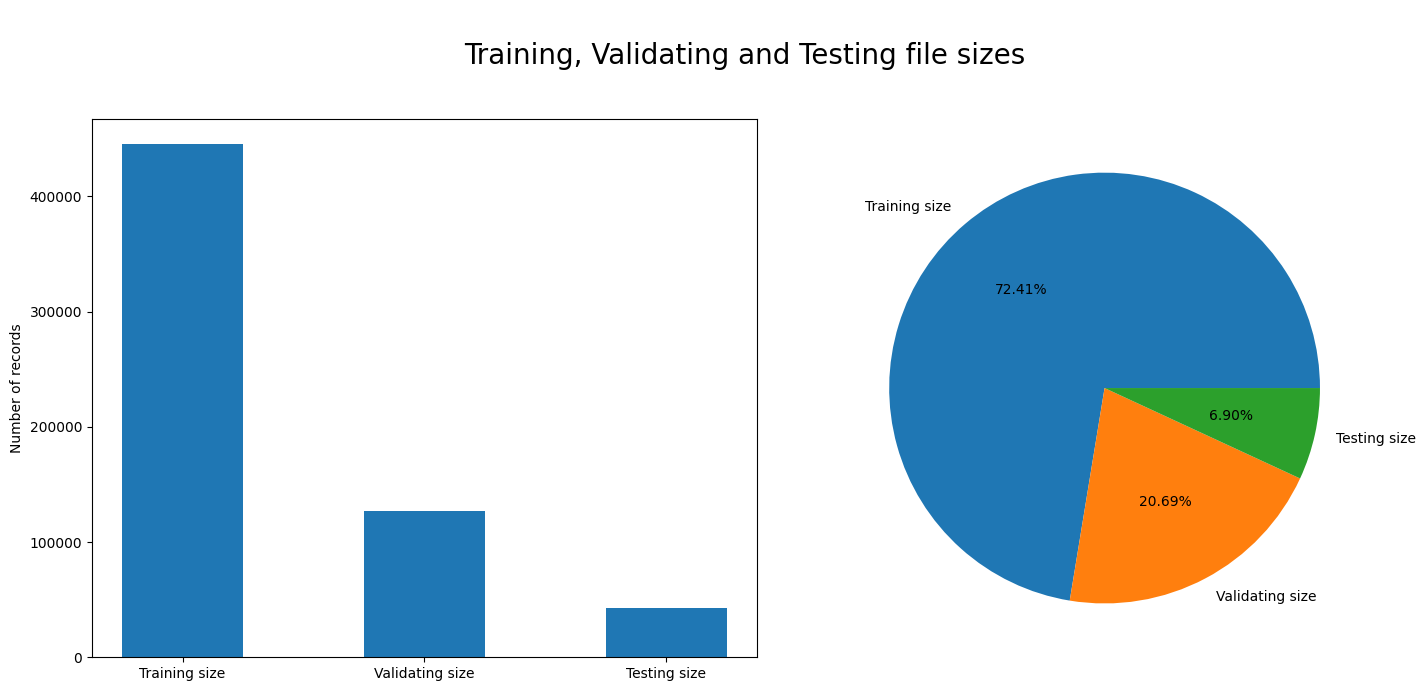

In [1131]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

colors=['#99CCFF', '#C0DCFF', '#DAEDFF']

train_size = train_df.size
val_size = val_df.size
test_size = test_df.size

print(f"Training Dataset size: {train_size}")
print(f"Validating Dataset size: {val_size}")
print(f"Testing Dataset size: {test_size}")

sizes = [train_size, val_size, test_size]
labels = ["Training size", "Validating size", "Testing size"]

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].bar(labels, sizes, width=0.5)
axes[0].set_ylabel("Number of records")

axes[1].pie(sizes, labels=labels, autopct="%1.2f%%")

plt.suptitle("\nTraining, Validating and Testing file sizes\n", fontsize=20)
plt.tight_layout()
plt.show()

From the results above we can easily tell that our dataset files satisfy the data splitting criterion.

### Data Analysis and Cleaning 📈📊🧹

The first step of the whole process is to **pre-process** and **clean** our dataset files. In Machine Learning and AI applications, this is the initial and really important step. We will focus on
1. Transform shortcuts like **"I'm" to "I am"**.
2. Removing **URLs**, **User mentions**, **Hashtags** and **special characters**.
3. **Lowercasing** the texts
4. Removing **extra spaces** and **line breaks**
5. Applying **stemming** and **lemmatization**

Let's begin by implementing a **function** that will handle the data pre-processing for a given string.

In [1132]:
import os
import re
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet

# nltk.download('wordnet')
# nltk.download('omw-1.4')

# stemmer = PorterStemmer()
# lemmatizer = WordNetLemmatizer()

def clean_text(text: str) -> str:
    text = text.lower() # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text) # Remove url links
    text = re.sub(r"@\w+", "USER", text) # Remove mentions
    text = re.sub(r"#(\w+)", r"\1", text) # Remove hastags
    text = re.sub(r"&[^;\s]+;", "", text) # Remove special characters
    text = re.sub(r"\s+", " ", text) # Remove extra spaces

    text = text.replace("'s", "is")
    text = text.replace("n't", "not")
    text = text.replace("i'm", "i am")
    text = text.replace("im", "i am")
    text = text.replace("4all", "for all")
    text = text.replace(" u ", " you ")
    text = text.replace(" ur ", " you are ")
    text = text.replace(" itis ", " it is ")
    text = text.replace(" lol ", " laughing out loud ")
    text = text.replace(" ame ", " i am a ")
    text = text.replace(" ti ", " the ")
    text = text.replace(" canot ", " cannot ")
    text = text.replace(" donot ", " do not ")
    text = text.replace("'ll", " will")
    text = text.replace(" na ", " no ")
    text = text.replace("heyyyy", "hey")
    
    text = re.sub(r"\b(luv)\b", "love", text)
    text = re.sub(r"\b(amzing)\b", "amazing", text)
    text = re.sub(r"\b(terible)\b", "terrible", text)
    text = re.sub(r"\b(excelent)\b", "excellent", text)
    text = re.sub(r"\b(performnce)\b", "perfomance", text)
    text = re.sub(r"\b(gud)\b", "good", text)
    text = re.sub(r"\b(vry)\b", "very", text)
    text = re.sub(r"\b(fantstic)\b", "fantastic", text)
    text = re.sub(r"\b(gr8)\b", "great", text)
    text = re.sub(r"\b(horrble)\b", "horrible", text)
    text = re.sub(r"\d+", "", text)
    
#     words = text.split()
#     stemmed_words = [stemmer.stem(word) for word in words] # Apply stemming
#     lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words] # Apply lemmatization
#     text = " ".join(lemmatized_words)
    
    return text

Let's apply this function to the 3 dataset files, and see the results.

In [1133]:
import time

# Apply the cleaning function to every dataset file and create a new column with the modified text
start_time = time.time()
train_df["Cleaned_text"] = train_df["Text"].apply(clean_text)
val_df["Cleaned_text"] = val_df["Text"].apply(clean_text)
test_df["Cleaned_text"] = test_df["Text"].apply(clean_text)
end_time = time.time()

print(f"Datasets were cleaned in {end_time - start_time} seconds.")

train_df.head(10)

Datasets were cleaned in 6.570500135421753 seconds.


,ID,Text,Label,Cleaned_text
53149,11245,tomorrow fb is leaving,0,tomorrow fb is leaving
119783,70451,@kyletamo My copy finally arrived. Sounds awe...,1,USER my copy finally arrived. sounds awesome! ...
60918,170595,10% battery remaining on iTouch.. No music... ...,0,% battery remaining on itouch.. no music... no...
70124,71169,@dddani_ I haven't watched Taken yet. Heard i...,1,USER i havenot watched taken yet. heard its a ...
86977,49305,Just finished taking world geograhy final!!! I...,0,just finished taking world geograhy final!!! i...
91486,18803,@keza34 same here yeahh im goin shoppin/cinem...,1,USER same here yeahh i am goin shoppin/cinema ...
25222,30113,"Hm, 2GB/6hours = 0.33gb/hour, 0.33gb/60(min) =...",1,"hm, gb/hours = .gb/hour, .gb/(min) = .gb/min, ..."
145105,155286,"Two hardest exams down. Two to go. Thankfully,...",1,"two hardest exams down. two to go. thankfully,..."
5690,38521,"aww, no one wants to talk to me.",0,"aww, no one wants to talk to me."
50559,5155,IM SO WACTHIN RUNS HOUSE DO I SEE MY BOO &quot...,0,i am so wacthin runs house do i see my boo ja ...


We will now proceed to **analyze** the **training dataset**. We are going to focus on the **words** of each tweet and extract the most frequent ones, by generating a **Word Cloud** and a **Bar Plot**.

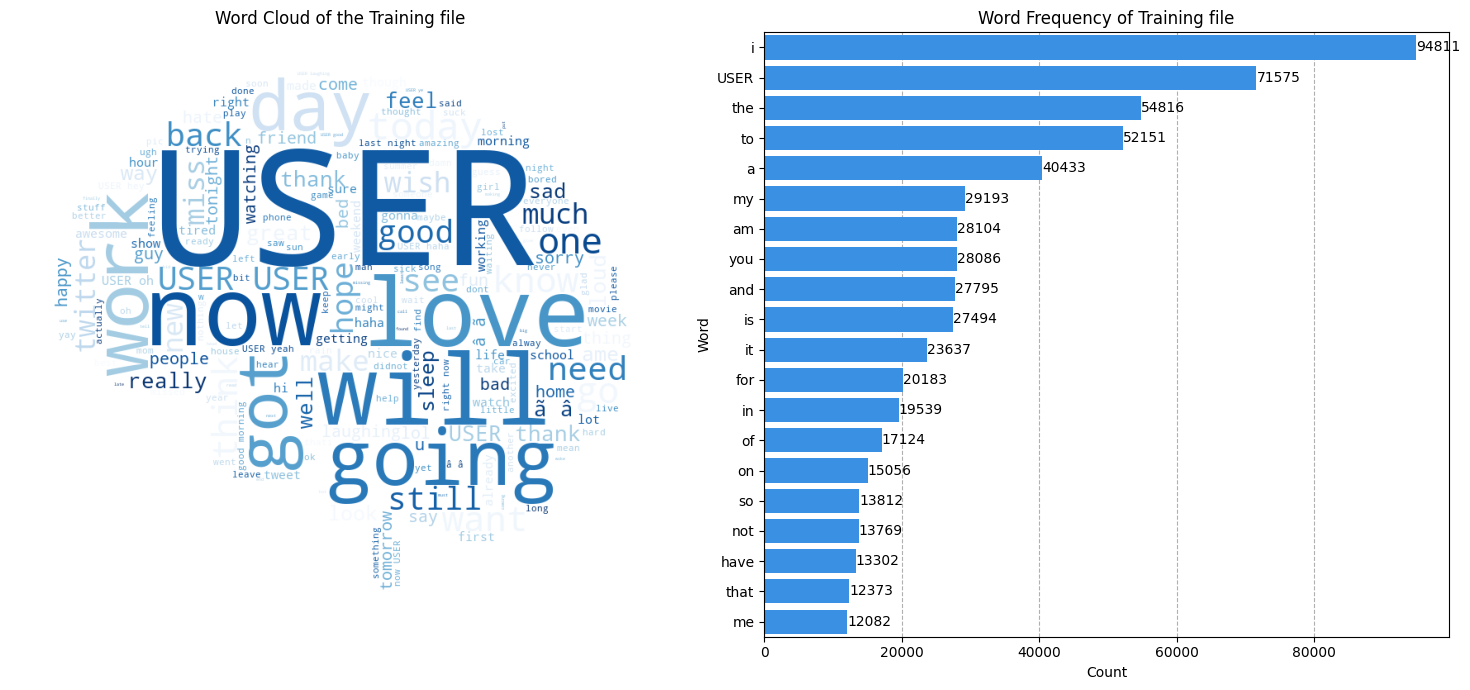

In [1134]:
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
import numpy as np
import PIL.Image

brain_mask = np.array(PIL.Image.open(images_base_filepath + "/brain_logo.jpg"))

def analize_words(df: pd.DataFrame, column: str, bar_color="#7AC2FF"):
    all_text = " ".join(df[column])
    all_words = " ".join(df[column]).split()
    
    word_counts = Counter(all_words)
    most_common_words = word_counts.most_common(20)
    
    common_df = pd.DataFrame(most_common_words, columns=["Word", "Count"])
    
    wordcloud = WordCloud(width=800, height=800, background_color="#FFF", colormap="Blues", mask=brain_mask)
    wordcloud.generate(all_text)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    axes[0].imshow(wordcloud)
    axes[0].axis("off")
    axes[0].set_title("Word Cloud of the Training file")
    
    axes[1].set_axisbelow(True)
    axes[1].grid(zorder=1, linestyle='dashed')
    bars = sns.barplot(x="Count", y="Word", data=common_df, color=bar_color, ax=axes[1])
    bars.bar_label(bars.containers[0])
    axes[1].set_title("Word Frequency of Training file")
    
    # plt.savefig(filename)
    plt.tight_layout()
    plt.show()

analize_words(train_df, column='Cleaned_text', bar_color='dodgerblue')

The above graphs reveal to us the frequency of some words inside the dataset. The plot on the right appears to have words that are not practically useful. These words are called **stopwords** and the `wordcloud` Python package automatically ignores them. That's because we have different results on the left and right plots. Having stopwords in our dataset is not a good practice for sentiment analysis because stopwords do not add much meaning. So we will take care of them by removing them from the dataset.

In [1135]:
import nltk
from nltk import data
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import time

warnings.filterwarnings("ignore", category=UserWarning, module="nltk")
nltk.download('stopwords')

def remove_stopwords(text: str) -> str:
    # Remove the stopwords from the original text
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_words = [word for word in word_tokens if word not in stop_words]

    return " ".join(filtered_words)

start_time = time.time()
train_df['Cleaned_text'] = train_df['Cleaned_text'].apply(remove_stopwords)
val_df['Cleaned_text'] = val_df['Cleaned_text'].apply(remove_stopwords)
test_df['Cleaned_text'] = test_df['Cleaned_text'].apply(remove_stopwords)
end_time = time.time()


print(f"Stopwords were removed in {end_time - start_time} seconds.")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Antonis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Stopwords were removed in 77.0520749092102 seconds.


By executing the code above we must have removed some useless stopwords from the dataset. Let's have a look at the dataset and the analytics one more time.

In [1136]:
train_df.head(10)

,ID,Text,Label,Cleaned_text
53149,11245,tomorrow fb is leaving,0,tomorrow fb leaving
119783,70451,@kyletamo My copy finally arrived. Sounds awe...,1,USER copy finally arrived . sounds awesome ! l...
60918,170595,10% battery remaining on iTouch.. No music... ...,0,% battery remaining itouch .. music ... twitte...
70124,71169,@dddani_ I haven't watched Taken yet. Heard i...,1,USER havenot watched taken yet . heard thrille...
86977,49305,Just finished taking world geograhy final!!! I...,0,finished taking world geograhy final ! ! ! thi...
91486,18803,@keza34 same here yeahh im goin shoppin/cinem...,1,USER yeahh goin shoppin/cinema wiv mii friend ...
25222,30113,"Hm, 2GB/6hours = 0.33gb/hour, 0.33gb/60(min) =...",1,"hm , gb/hours = .gb/hour , .gb/ ( min ) = .gb/..."
145105,155286,"Two hardest exams down. Two to go. Thankfully,...",1,"two hardest exams . two go . thankfully , 're ..."
5690,38521,"aww, no one wants to talk to me.",0,"aww , one wants talk ."
50559,5155,IM SO WACTHIN RUNS HOUSE DO I SEE MY BOO &quot...,0,wacthin runs house see boo ja rleitsss murderr...


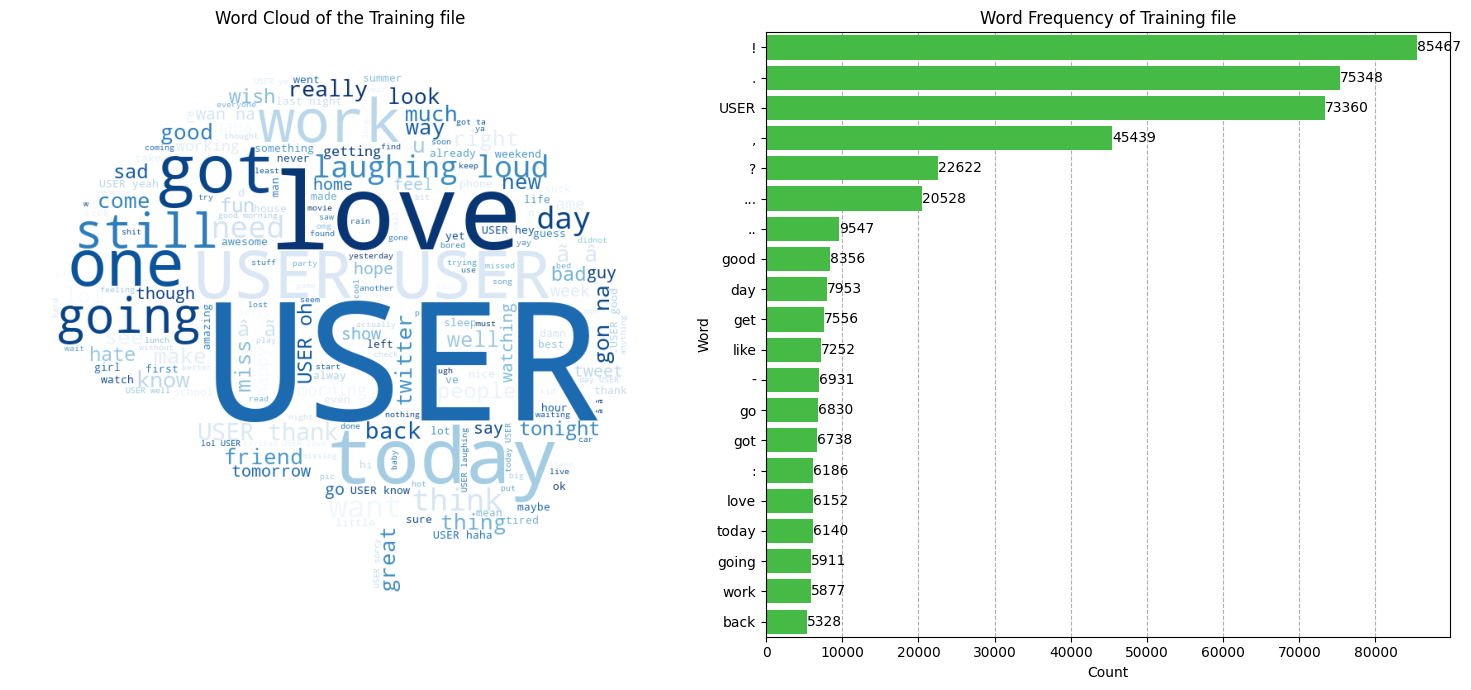

In [1137]:
analize_words(train_df, column='Cleaned_text', bar_color="limegreen")

As we expected all the common stopwords like 'I', 'the', 'so' and more have been deleted from the records of the dataset. However we have another error this time refering to punctuation. Symbols like '!', '?' and so on, must not be inside the dataset. Let's delete them and take another look at the statistics.

In [1138]:
from nltk.tokenize import word_tokenize
import string

special_punctuation = ['...', '..']

def remove_punctuation(text: str) -> str:
    word_tokens = [w for w in text.split()]
    filtered_words = [word for word in word_tokens if word not in string.punctuation and word not in special_punctuation]
    return " ".join(filtered_words)

train_df['Cleaned_text'] = train_df['Cleaned_text'].apply(remove_punctuation)
val_df['Cleaned_text'] = val_df['Cleaned_text'].apply(remove_punctuation)
test_df['Cleaned_text'] = test_df['Cleaned_text'].apply(remove_punctuation)

In [1139]:
train_df.head(10)

,ID,Text,Label,Cleaned_text
53149,11245,tomorrow fb is leaving,0,tomorrow fb leaving
119783,70451,@kyletamo My copy finally arrived. Sounds awe...,1,USER copy finally arrived sounds awesome like ...
60918,170595,10% battery remaining on iTouch.. No music... ...,0,battery remaining itouch music twitter. faceboook
70124,71169,@dddani_ I haven't watched Taken yet. Heard i...,1,USER havenot watched taken yet heard thriller ...
86977,49305,Just finished taking world geograhy final!!! I...,0,finished taking world geograhy final think bad
91486,18803,@keza34 same here yeahh im goin shoppin/cinem...,1,USER yeahh goin shoppin/cinema wiv mii friend ...
25222,30113,"Hm, 2GB/6hours = 0.33gb/hour, 0.33gb/60(min) =...",1,hm gb/hours .gb/hour .gb/ min .gb/min .gb/ sec...
145105,155286,"Two hardest exams down. Two to go. Thankfully,...",1,two hardest exams two go thankfully 're somewh...
5690,38521,"aww, no one wants to talk to me.",0,aww one wants talk
50559,5155,IM SO WACTHIN RUNS HOUSE DO I SEE MY BOO &quot...,0,wacthin runs house see boo ja rleitsss murderr...


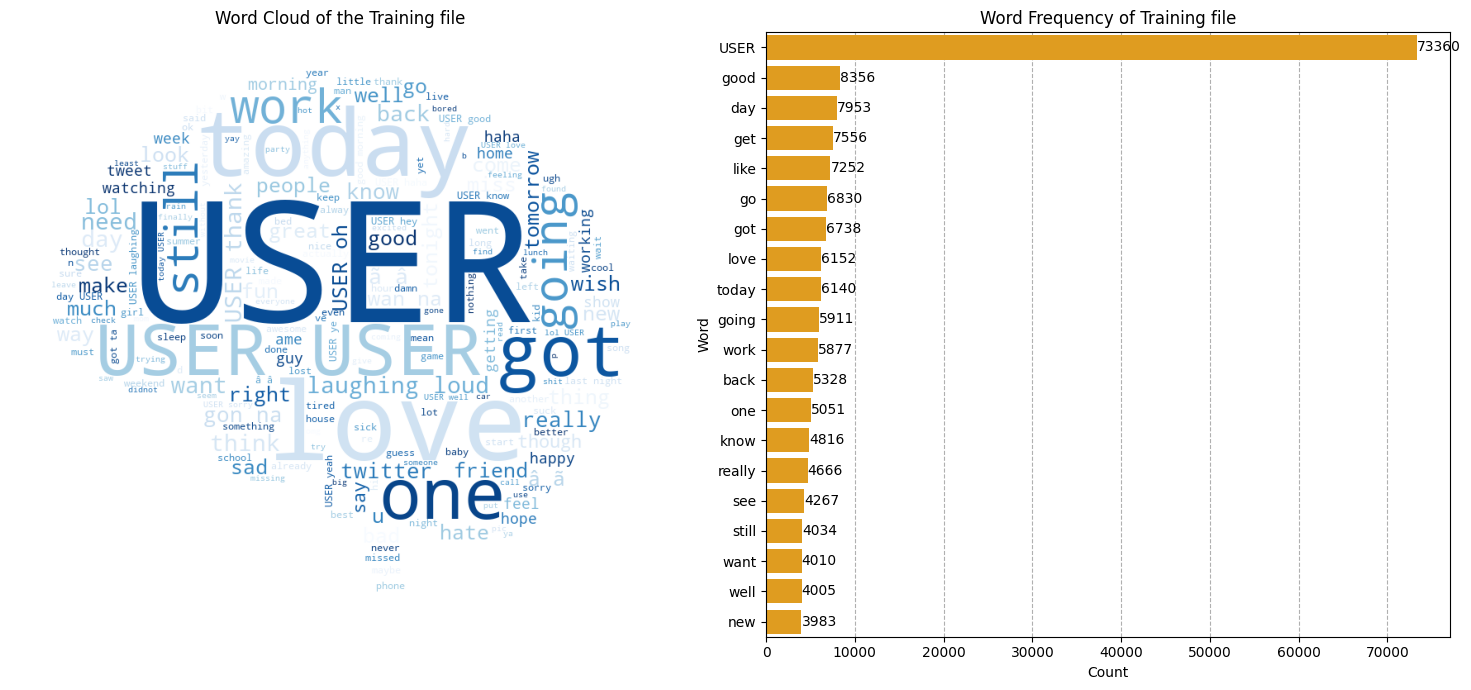

In [1140]:
analize_words(train_df, column='Cleaned_text', bar_color="orange")

As we can see the dataset has been cleaned successfully and there not any stopwords or punctuation symbols in the records. The only thing left is to remove any missing values.

### Deeper Analysis 🔎📊

We are now going to fall into a deeper analysis of the dataset, in order to collect some information about the user comments.

#### Sentiment Distribution Analysis

First we will attempt to do a **sentiment distribution analsysis** to training and validating dataset files. Specifically we will count the number of tweets for each sentiment in both training and validating files.

In [1141]:
def get_sentiment_distribution(df: pd.DataFrame) -> tuple[int, int]:
    positive_count, negative_count = 0, 0
    for label in df['Label']:
        if label == 1: positive_count += 1
        else: negative_count += 1

    return positive_count, negative_count

Training file has 74196 positive tweets and 74192 negative tweets
Validating file has 21199 positive tweets and 21197 negative tweets


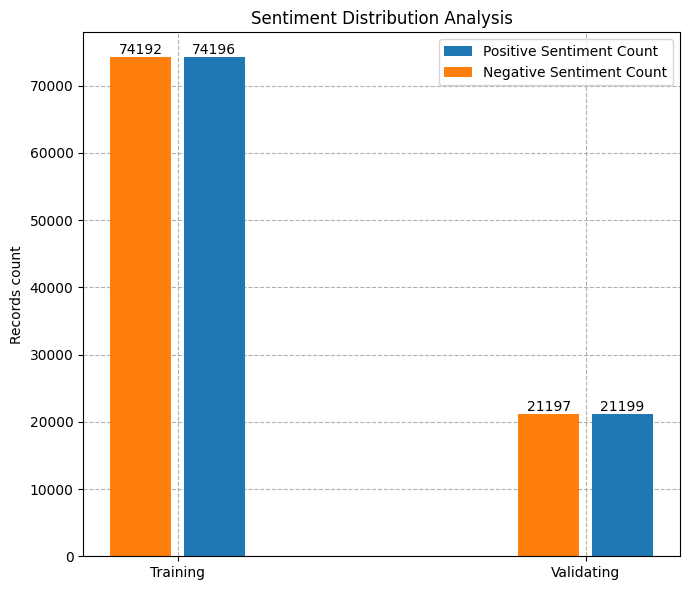

In [1142]:
import numpy as np

# Get the sentiment distribution analysis of training and validating files
train_sent_dist = get_sentiment_distribution(train_df)
val_sent_dist = get_sentiment_distribution(val_df)

print(f"Training file has {train_sent_dist[0]} positive tweets and {train_sent_dist[1]} negative tweets")
print(f"Validating file has {val_sent_dist[0]} positive tweets and {val_sent_dist[1]} negative tweets")

files_labels = ["Training", "Validating"]

bar_width = 0.15
gap = 0.015

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.set_axisbelow(True)
ax.grid(zorder=1, linestyle='dashed')
positive_bar = ax.bar(np.arange(len(files_labels)) + bar_width/2+gap, [train_sent_dist[0], val_sent_dist[0]], width=bar_width, label='Positive Sentiment Count')
negative_bar = ax.bar(np.arange(len(files_labels)) - bar_width/2-gap, [train_sent_dist[1], val_sent_dist[1]], width=bar_width, label='Negative Sentiment Count')

ax.bar_label(positive_bar, label_type='edge')
ax.bar_label(negative_bar, label_type='edge')

ax.set_title('Sentiment Distribution Analysis')
ax.set_ylabel('Records count')

ax.set_xticks(np.arange(len(files_labels)))
ax.set_xticklabels(files_labels)

plt.legend()
plt.tight_layout()

# plt.savefig('../plots/dataset_sentiment_distribution.png')
plt.show()

As we can see the number of positive and negative tweets inside the training and validating dataset files are **almost equal**. In both files the positive tweets prevail over the negative ones. Generally we can say that the dataset is **balanced**.

#### Sentiment Correlation

Finally we will do some **sentiment correlation** with **specific words**. In other words we will identify the words that are highly correlated with a specific sentiment. Let's begin by splitting the training dataset into two data frames containing all the positive and negative tweets.

In [1143]:
train_positive_df = train_df[train_df['Label'] == 1]
train_negative_df = train_df[train_df['Label'] == 0]

In [1144]:
train_positive_df.head()

,ID,Text,Label,Cleaned_text
119783,70451,@kyletamo My copy finally arrived. Sounds awe...,1,USER copy finally arrived sounds awesome like ...
70124,71169,@dddani_ I haven't watched Taken yet. Heard i...,1,USER havenot watched taken yet heard thriller ...
91486,18803,@keza34 same here yeahh im goin shoppin/cinem...,1,USER yeahh goin shoppin/cinema wiv mii friend ...
25222,30113,"Hm, 2GB/6hours = 0.33gb/hour, 0.33gb/60(min) =...",1,hm gb/hours .gb/hour .gb/ min .gb/min .gb/ sec...
145105,155286,"Two hardest exams down. Two to go. Thankfully,...",1,two hardest exams two go thankfully 're somewh...


In [1145]:
train_negative_df.head()

,ID,Text,Label,Cleaned_text
53149,11245,tomorrow fb is leaving,0,tomorrow fb leaving
60918,170595,10% battery remaining on iTouch.. No music... ...,0,battery remaining itouch music twitter. faceboook
86977,49305,Just finished taking world geograhy final!!! I...,0,finished taking world geograhy final think bad
5690,38521,"aww, no one wants to talk to me.",0,aww one wants talk
50559,5155,IM SO WACTHIN RUNS HOUSE DO I SEE MY BOO &quot...,0,wacthin runs house see boo ja rleitsss murderr...


Let's find and plot the **30 most common** words in each data frame.

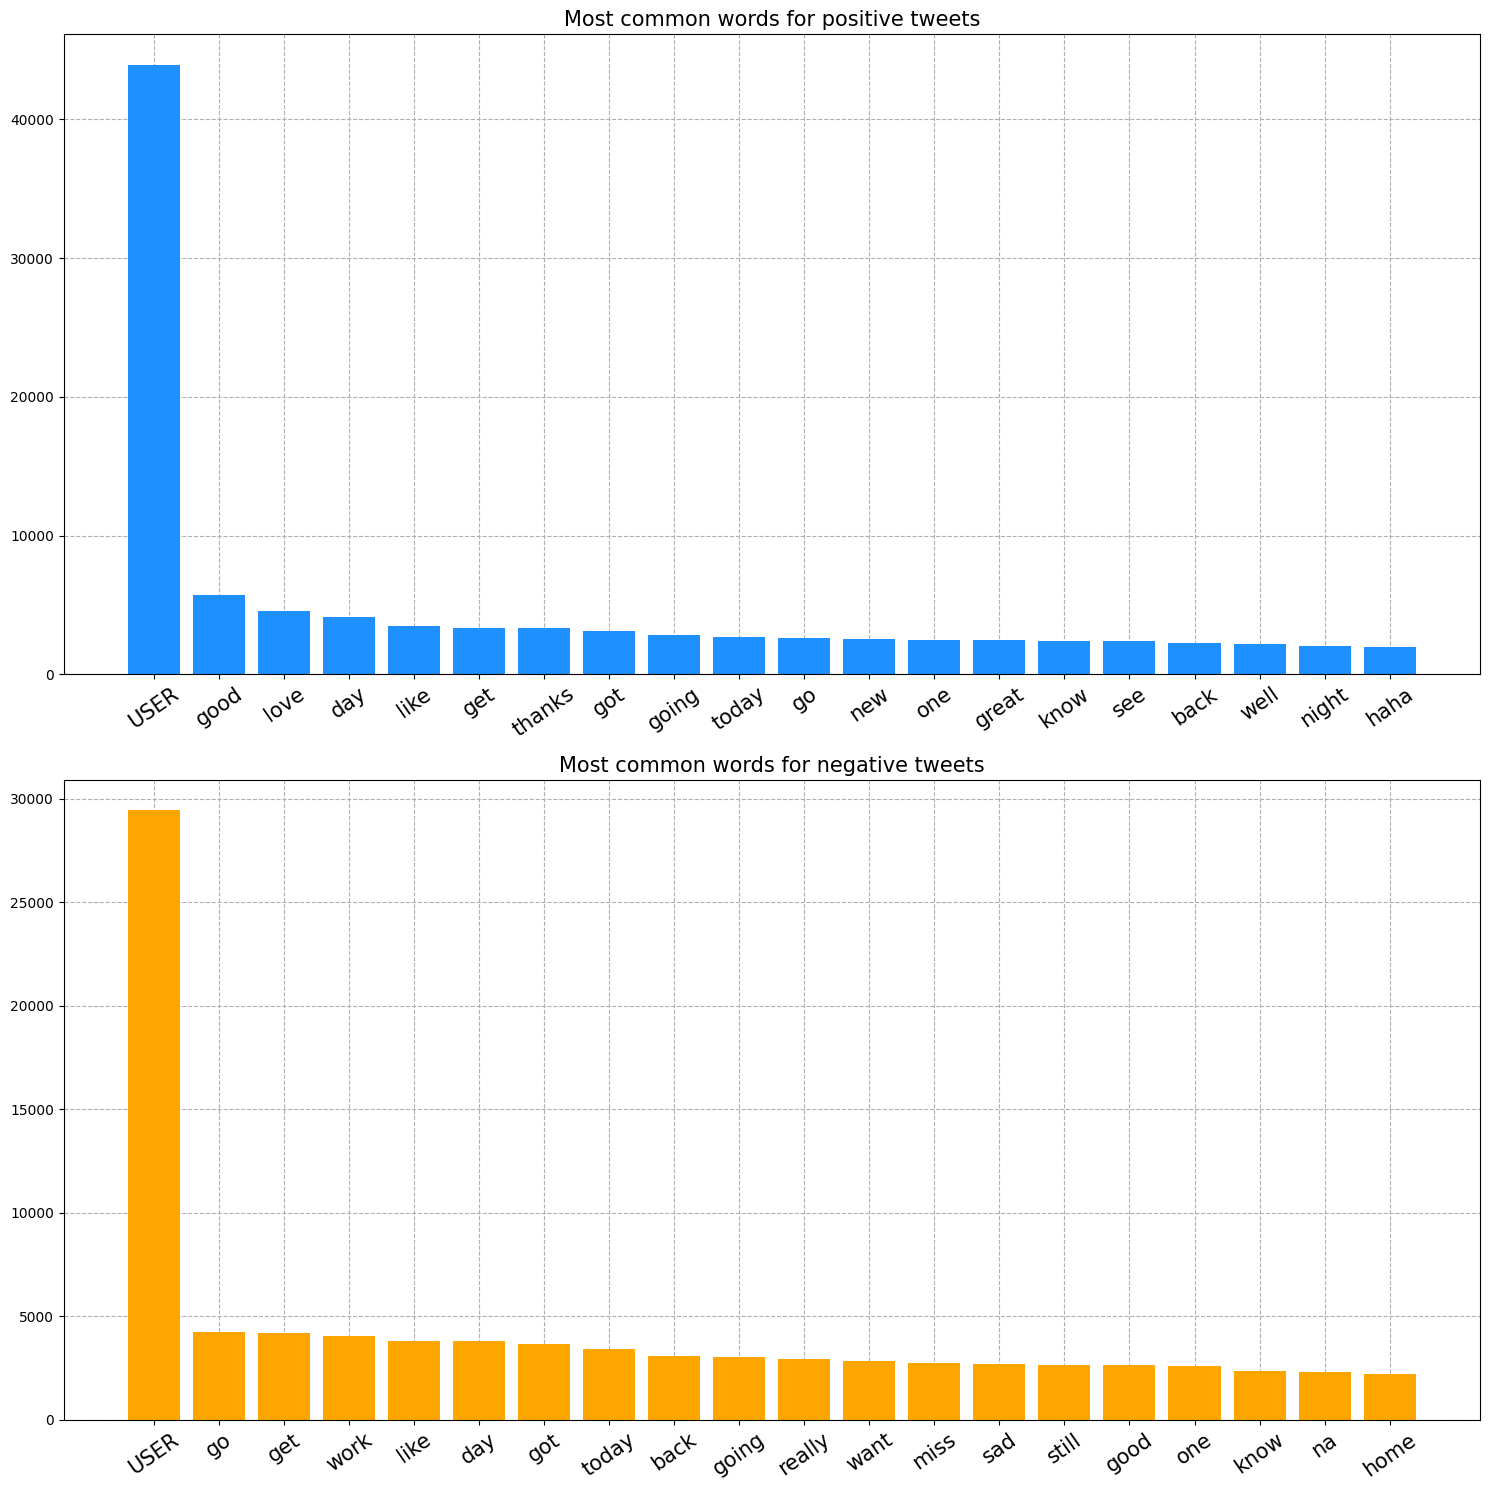

In [1146]:
from collections import Counter

# Receive all the words from the positive dataframe
all_train_positive_text = " ".join(train_positive_df['Cleaned_text'])
all_train_positive_words = all_train_positive_text.split()

# Find the most common words
train_positive_words_counter = Counter(all_train_positive_words)
most_common_train_positive_words = train_positive_words_counter.most_common(20)

# Receive all the words from the negative dataframe
all_train_negative_text = " ".join(train_negative_df['Cleaned_text'])
all_train_negative_words = all_train_negative_text.split()

# Find the most common words
train_negative_words_counter = Counter(all_train_negative_words)
most_common_train_negative_words = train_negative_words_counter.most_common(20)

# Plot the data
positive_labels = [word[0] for word in most_common_train_positive_words]
positive_count = [word[1] for word in most_common_train_positive_words]

negative_labels = [word[0] for word in most_common_train_negative_words]
negative_count = [word[1] for word in most_common_train_negative_words]

fig, axes = plt.subplots(2, 1, figsize=(15, 15))
axes[0].set_axisbelow(True)
axes[0].grid(zorder=1, linestyle='dashed')
axes[0].bar(positive_labels, positive_count, color="dodgerblue")
axes[0].set_title('Most common words for positive tweets', fontsize=15)
axes[0].set_xticklabels(labels=positive_labels, rotation=35, fontsize=15)

axes[1].set_axisbelow(True)
axes[1].grid(zorder=1, linestyle='dashed')
axes[1].bar(negative_labels, negative_count, color="orange")
axes[1].set_title('Most common words for negative tweets', fontsize=15)
axes[1].set_xticklabels(labels=negative_labels, rotation=35, fontsize=15)

# plt.savefig('../plots/most_common_words.png')
plt.tight_layout()
plt.show()

As we can see the most common word for positive tweets is **'get'** and for negative tweets is the word **'go'**.

## Training the model 🤖🧠

We will now perform the **training process** of the model. We will start by initializing the **TF-IDF** vectorizer.

In [1147]:
train_df

,ID,Text,Label,Cleaned_text
53149,11245,tomorrow fb is leaving,0,tomorrow fb leaving
119783,70451,@kyletamo My copy finally arrived. Sounds awe...,1,USER copy finally arrived sounds awesome like ...
60918,170595,10% battery remaining on iTouch.. No music... ...,0,battery remaining itouch music twitter. faceboook
70124,71169,@dddani_ I haven't watched Taken yet. Heard i...,1,USER havenot watched taken yet heard thriller ...
86977,49305,Just finished taking world geograhy final!!! I...,0,finished taking world geograhy final think bad
...,...,...,...,...
16627,49770,i had to leave training. i got done an hour be...,0,leave training got done hour everyone else kee...
95452,160095,@alcedine @heartagram congrats on the new kitt...,1,USER USER congrats new kitties two definitely ...
110380,2303,@toritos he's pretty good at skulls. and i tal...,1,USER heis pretty good skulls talked hi yesterd...
32301,163244,I am disgustingly full. I hate this feeling!,0,disgustingly full hate feeling


### Vectorizing the data
We will start by **vectorizing** our data.

In [1148]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_data(train_df, val_df, test_df):
    vectorizer = TfidfVectorizer(
        stop_words="english"
    )

    X_train = vectorizer.fit_transform(train_df['Cleaned_text'])
    X_val = vectorizer.transform(val_df['Cleaned_text'])
    X_test = vectorizer.transform(test_df['Cleaned_text'])
    
    y_train = train_df['Label']
    y_val = val_df['Label']

    return X_train, X_val, X_test, y_train, y_val

In [1149]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Load the data and vectorize them using TF-IDF method
X_train, X_val, X_test, y_train, y_val = vectorize_data(train_df, val_df, test_df)
print(X_train.shape, X_val.shape)

(148388, 66877) (42396, 66877)


Our result matrix is a $148388 \times 13316$ on which the rows represent the documents and the columns represent the words.

### Default Prediction
We will start by executing a default (dummy) prediction on our **validation data** without having a trained model.

In [1150]:
batch_size = 1000  

weights, bias = np.random.randn(X_val.shape[1], 1), np.random.randn()
y_pred = np.zeros((X_val.shape[0], 1))  # Placeholder for predictions

# Use batches for faster calculation
for i in range(0, X_val.shape[0], batch_size):
    batch_end = i + batch_size
    y_pred[i:batch_end] = X_val[i:batch_end] @ weights + bias

y_pred = np.where(y_pred >= 0.5, 1, 0)
accuracy = accuracy_score(y_val, y_pred)
print(f"Default Accuracy: {accuracy}")

Default Accuracy: 0.5092225681668082


As we can see a random default prediction gives an **accuracy** of about **0.5**. That is logical to happen due to the fact that the datasets are **balanced** as we saw previously.

### Logistic Regression Definition
We will continue by creating the model on which the training procedure will be done. This of course is based on the **Logistic Regression**. We will also train our model using the train file.

In [1151]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

### Testing the model
After the **model training**, the next step is to **test** the model using the **validation data**. We will test the model and print the **accuracy** and the **classification report**.

In [1152]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
print(f"Accuracy: {accuracy}\nClassification Report:\n{report}")

Accuracy: 0.7650957637512973
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     21197
           1       0.76      0.78      0.77     21199

    accuracy                           0.77     42396
   macro avg       0.77      0.77      0.77     42396
weighted avg       0.77      0.77      0.77     42396



As we se, the accuracy of the model is **around 0.767** and the **classification report** is being shown above. We can also plot the **confusion matrix** to take a better look at the results.

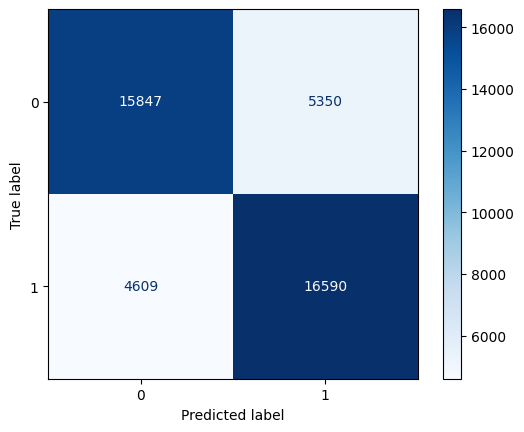

In [1153]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_val, y_pred),
    display_labels=model.classes_
)
disp.plot(cmap="Blues")
plt.show()

The confusion matrix shows the results of the model prediction on the validation data and we observe that **most of the time** the predictions were **correct**. There are although some mistakes, such as that 4554 positive comment where predicted as negative and 5299 negative were predicted as positive. 

Let's also plot the learning curves of the model.

In [1154]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=2, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10)
)

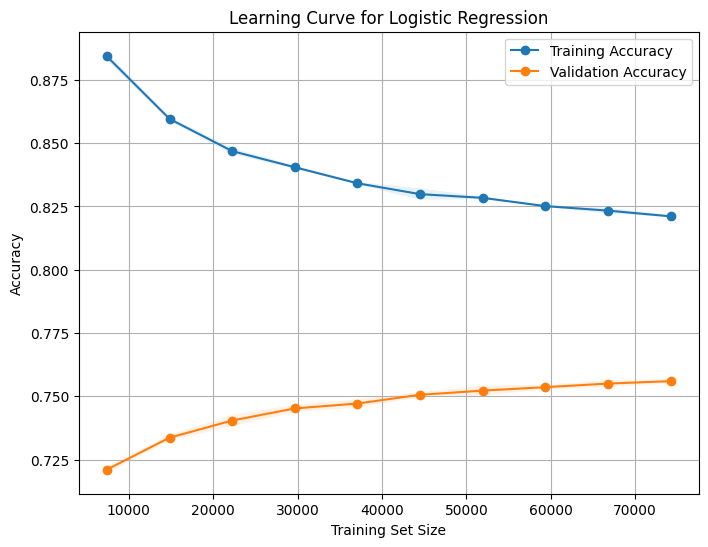

In [1155]:
# Compute mean and std deviation for shading
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(test_scores, axis=1)
val_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training Accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)

plt.plot(train_sizes, val_mean, 'o-', label="Validation Accuracy")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Logistic Regression")
plt.legend()
plt.grid()
plt.show()

In [1156]:
y_pred = model.predict(X_test)

submission_df = pd.DataFrame({'ID': test_df['ID'], 'Label': y_pred})
submission_df.to_csv('submission.csv', index=False)
submission_df

,ID,Label
0,102388,0
1,153802,0
2,61831,1
3,18317,1
4,50061,1
...,...,...
21194,101544,0
21195,5461,0
21196,135996,1
21197,157554,1
